# CircularRestricted.py

The CircularRestricted package is a Python utility for modeling the orbital motion of a satellite in multi-body gravipotential regimes, such as the Earth-Moon system, or the Earth-Sun system. Where possible, math operations are accelerated by pre-compiling in C using Numba. 

## Circular Restricted Three-Body Problem

The most basic multi-body problem is the CR3BP problem. Under this formulation, the satellite's motion is expressed relative to a common barycenter shared by two massive bodies. These bodies are assumed to have perfectly circular orbits about their common barycenter, such that their orbits share a constant angular rate. By choosing a rotating reference frame based on this constant angular rate whose origin is fixed at the barycenter, the more-massive (primary) body can be fixed on the negative *X* axis and the less-massive (secondary) body is fixed on the postive *X* axis. The positive *Y* direction is defined as the direction of the secondary body's tangential orbit velocity, and the *Z* axis completes the right-handed axis system (and is parallel to the secondary body's angular momentum vector). In this formulation, there are 5 equilibrium points (called Lagrange points) in the gravipotential field. Three lie on the *X* axis, and are unstable equilibria (saddle points); the remaining two are vertices of two equilateral triangles where the other two vertices are the center of the primary and secondary bodies, and are stable equilibria. 

## Example 1: Instantiating a scenario

First, import the CR3BP class from CircularRestricted.py. You will also need to provide input values as AstroPy units. The Poliastro package also makes it easy to access constants of certain celestial bodies, so we will import those as well.

In [1]:
from CircularRestricted import CR3BP
from astropy import units as u
from poliastro.bodies import Sun, Moon, Earth

To instantiate a CR3BP scenario, provide the primary body's mass, secondary body's mass, and the (assumed constant) distance between them as AstroPy units of kg, kg, and km respectively.

In [2]:
EM = CR3BP(Earth.mass, Moon.mass, 384400*u.km)

Let's explore some of the attributes of our object using the CR3BP.summary() method. This prints several attributes and plots a sketch of the system with Lagrange points shown. For differently sized and spaced bodies, the positions of the collinear Lagrange points can shift considerably.

CR3BP constant (μ):  0.012150584709882378
  -  Note: μ is defined as m2 / (m1 + m2)
Primary body mass (m1): 5.972168e+24 kg
Secondary body mass (m2): 7.345789e+22 kg
Primary-Secondary distance:  384400.0 km
L1 position (non-dimensional): 0.836915
L2 position (non-dimensional): 1.155682


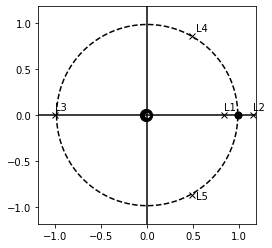

In [3]:
EM_fig, EM_ax = EM.summary()

In the summary above, the L1 and L2 positions are given in non-dimensional units. What are these? Quantities in these scenarios are often normalized to non-dimensional units to avoid performing computations with very large or very small numbers. This helps preserve the validity of numerical methods that are used to propagate these trajectories. Numerical methods are required because there is no closed-form analytical solution for the motion of an object in these dynamics. 

In order to navigate the conversion between conventional and non-dimensional units, you can use the CR3BP.convert() method, as shown below:

In [9]:
L1_nondim = EM.xL['L1']
print('L1 position (non-dimensional): ',EM.xL['L1'])

L1_km = EM.convert(L1_nondim, to='km')
print('L1 position (in kilometers): ', L1_km)

L1_m = EM.convert(L1_nondim, to='m')
print('L1 position (in meters): ', L1_m)

L1_pc = EM.convert(L1_nondim, to='parsec')
print('L1 position (in parsecs): ', L1_pc)

L1 position (non-dimensional):  0.8369151301995564
L1 position (in kilometers):  321710.1760487095 km
L1 position (in meters):  321710176.0487095 m
L1 position (in parsecs):  1.0425916757421583e-08 pc


In this scenario, the following quantities are converted to nondimensional values:
- Length (normalized by the primary-secondary distance)
- Mass (normalized by the sum of the primary & secondary masses)
- Time (normalized by the period of the primary-secondary orbit)
- Any combination of these units (e.g. Velocity, Acceleration)

The CR3BP.convert() method will also know how to convert values into nondimensional units if they are passed as AstroPy Quantities. For example:

In [20]:
qty1 = 77*u.km/u.hr
print('In non-dimensional units, ',qty1, ' is ', EM.convert(qty1))

qty2 = 209809*u.mm/(u.d**2)
print('In non-dimensional units, ',qty2, ' is ', EM.convert(qty2))

qty3 = 1*u.yr
print('In non-dimensional units, ',qty3, ' is ', EM.convert(qty3))


In non-dimensional units,  77.0 km / h  is  0.020876439073891046
In non-dimensional units,  209809.0 mm / d2  is  1.0292394020069435e-05
In non-dimensional units,  1.0 yr  is  84.11092132325106


It is also helpful to know how to use AstroPy to convert units using the Quantity.to() method, which is very handy:

In [22]:
print( (1*u.yr).to('day') )

365.25 d


In [ ]:
from timeit import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(20.0,10.0);

fig, ax = EM.summary();

sc = Spacecraft(EM, X0 = [0.84,0.01,0, 0,0,0])
prop = Propagator(EM, sc, 'numbalsoda')
T, X = sc.propagate(prop)
dur = EM.convert(T[-1],to='day')

ax.plot(X[0],X[1])
ax.set_title('Spacecraft propagated over %0.2f days'%dur.value);
# EM.convert(T[-1],to='day')

In [ ]:
%timeit T, X = sc.propagate(prop)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(20.0,10.0)

X1 = np.linspace(-0.05,0.05,10000)
X2 = np.linspace(-1,1,10000)
Y1 = np.sqrt(0.05**2-X1**2)
Y2 = np.sqrt(1-X2**2)

fig, ax = plt.subplots()
ax.plot(X1,Y1,'--k')
ax.plot(X1,-Y1,'--k')
ax.plot(X2,Y2,'--k')
ax.plot(X2,-Y2,'--k')
ax.plot([-1.2,1.2],[0,0],'k')
ax.plot([0,0],[-1.2,1.2],'k')
ax.scatter(1,0,fc='k',s=50)
ax.scatter(-0.05,0,fc='k',s=150)
ax.plot(0.9,0,'kx')
ax.text(0.88,0.05,'L1')
ax.plot(1.1,0,'kx')
ax.text(1.08,0.05,'L2')
ax.plot(-1,0,'kx')
ax.text(-0.95,0.05,'L3')
ax.plot(0.45,np.sqrt(1-0.45**2),'kx')
ax.text(0.45+0.05,np.sqrt(1-0.45**2)+0.05,'L4')
ax.plot(0.45,-np.sqrt(1-0.45**2),'kx')
ax.text(0.45+0.05,-np.sqrt(1-0.45**2)-0.05,'L5')

ax.text(0.4,-0.05,'X axis')
ax.text(-0.05,0.4,'Y axis', rotation=90)

ax.scatter(0,0,fc='w',ec='k')
ax.set(xlim=[-1.2,1.2],ylim=[-1.2,1.2])
ax.set_aspect('equal')
ax.set_title('The Circular Restricted Three Body Problem',fontsize=20);

In [ ]:
a_earth = 1.0 * u.au  # km - 1 AU

# Use Poliastro to get body masses: Earth, Moon
# Then instantiate the CR3BP using the Synodic (rotating) Barycentric reference frame
frame = CR3BP(Sun.mass, Earth.mass, a_earth)

mu = frame.mu
xL, yL = frame.xL['L1'], frame.yL['L1']
ac = frame.convert((0.26 * u.mm/(u.s**2)).to('km/s2'))
sc = Spacecraft(frame, ar=ac, at=ac)
sc.set_initial_state([sc.xL_aug-1e-6, 1e-6, 1e-6, 0, 0, 0])
K_xy  = 1
K_z   = 2
db_xy = 0.0003
db_z  = 0.003
sc.set_thrust_profile('sail_control', sc.xL_aug, K_xy, K_z, db_xy, db_z)

# print(sc.controller_params)
prop = Propagator(frame, sc, method='numbalsoda', )


In [ ]:
T, X = prop.integrate(2*np.pi)
plt.plot(X[0],X[1])
plt.show()

In [ ]:
def num_sails(side_length, target_dist, percent_reduction=1.8):
    # Calculate subtended solid angle of the sun from the Earth
    R_sun = Sun.R.to('km').value
    D_sun = (1*u.au).to('km').value
    th_sun = np.arctan2(R_sun,D_sun)*u.rad
    sa_sun = 4*np.pi*np.sin(th_sun/2)**2 * u.sr
    # Calculate subtended solid angle of a single sail from the Earth
    R_sail = side_length.to('m')
    D_sail = target_dist.to('m')
    th_sail = np.arctan2(R_sail,D_sail)
    sa_sail = (th_sail**2).to('sr')
    # Determine number of sails needed to subtend a given amount 
    # (percent_reduction) of the sun's subtended area
    num_sails = int(np.ceil(((percent_reduction/100)/(sa_sail/sa_sun)).value))
    return "{:,} sailcraft".format(num_sails) + \
           " with %0.1f m^2 sail areas"%(side_length.to('m').value**2) + \
           " at a distance of {:,} km would be needed".format(
                np.round(target_dist.to('km').value)) + \
           " for a %0.2f%% reduction in solar irradiance"%(percent_reduction)

In [ ]:
xL_aug_dist = frame.convert((1-frame.mu),to='m') - frame.convert(sc.xL_aug,to='m')
xL_dist = frame.convert((1-frame.mu),to='m') - frame.convert(frame.xL['L1'],to='m')
num_sails(100*u.m, xL_aug_dist)

In [ ]:
num_sails(20*u.m, xL_dist)

In [ ]:
num_sails(20*u.m, xL_dist/3)

In [ ]:
frame2 = CR3BP(Earth.mass, Moon.mass, 384400*u.km)

In [ ]:
frame2.convert(frame2.xL['L2'],to='km')

In [ ]:
x_tgt = ((1-frame.mu) - ((1-frame.mu)-frame.xL['L1'])/0.5).value
print('x_tgt:  ', x_tgt)
print('xL:     ', frame.xL['L1'])
print('xL_aug: ', sc.xL_aug)

In [ ]:
x_tgt=0.99
X0 = [x_tgt+10e-6, -10e-6, 0, 0, 0, 0]
sc.set_initial_state(X0)
K_xy  = 1000
K_z   = 1
db_xy = 0.0001
db_z  = 0.001
sc.set_thrust_profile('sail_control', x_tgt, K_xy, K_z, db_xy, db_z)
T, X = sc.propagate(prop,t_max=2*np.pi, n=1000)

In [ ]:
plt.plot(X[0],X[1])
plt.plot(X[0][0],X[1][0],'ro')
plt.plot(x_tgt,0,'kx')

In [ ]:
ddX = CR3BP_EOM(frame.mu.value, np.array(X0,np.float64))
print(ddX)
print(ac)

In [ ]:
a_x, a_y, a_z, error, beta = sail_control_diagnostic(X, sc.ar, sc.at, x_tgt, K_xy, K_z, db_xy, db_z)
plt.subplot(321)
plt.plot(a_x)
plt.subplot(323)
plt.plot(a_y)
plt.subplot(325)
plt.plot(a_z)

plt.subplot(322)
plt.plot(error)
plt.subplot(324)
plt.plot(beta)
plt.ylim([0,2*np.pi])
plt.yticks([0,3.14,6.28]);

In [ ]:
plt.plot(0.5*np.pi*(1 - np.tanh(1e5*error)))

In [ ]:
periodic